In [2]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# Download data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [4]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

In [5]:
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [6]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3


In [7]:
# check that pipeline accepts strings
train.loc[train[target]==0, target] = "wealthy"
train.loc[train[target]==1, target] = "not_wealthy"

In [8]:
unused_feat = ['Set']
features = [col for col in train.columns if col not in unused_feat+[target]]
cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [17]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [ ]:
train.info()

In [10]:
train.head().T

,0,1,2,3,4
39,33,21,36,11,20
State-gov,6,4,4,4,4
77516,83311,215646,234721,338409,284582
Bachelors,9,11,1,9,12
13,12,8,6,12,13
Never-married,2,0,2,2,2
Adm-clerical,4,6,6,10,4
Not-in-family,0,1,0,5,5
White,4,4,2,2,4
Male,1,1,1,0,0


In [11]:
print(features)
print(cat_idxs)
print(cat_dims)

['39', ' State-gov', ' 77516', ' Bachelors', ' 13', ' Never-married', ' Adm-clerical', ' Not-in-family', ' White', ' Male', ' 2174', ' 0', ' 40', ' United-States']
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42]


In [13]:
from pytorch_tabnet.pretraining import TabNetPretrainer

In [14]:
# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax' # "sparsemax"
)

Device used : cpu


In [15]:
max_epochs = 1000

In [18]:
unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_valid],
    max_epochs=max_epochs , patience=5,
    batch_size=2048, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.8,
)

epoch 0  | loss: 3.28012 | val_0_unsup_loss: 1.64399 |  0:00:03s
epoch 1  | loss: 1.32805 | val_0_unsup_loss: 1.22339 |  0:00:06s
epoch 2  | loss: 1.14534 | val_0_unsup_loss: 1.10805 |  0:00:10s
epoch 3  | loss: 1.09746 | val_0_unsup_loss: 1.09452 |  0:00:13s
epoch 4  | loss: 1.07923 | val_0_unsup_loss: 1.0811  |  0:00:16s
epoch 5  | loss: 1.06692 | val_0_unsup_loss: 1.06259 |  0:00:19s
epoch 6  | loss: 1.05479 | val_0_unsup_loss: 1.0482  |  0:00:23s
epoch 7  | loss: 1.03909 | val_0_unsup_loss: 1.04181 |  0:00:26s
epoch 8  | loss: 1.0313  | val_0_unsup_loss: 1.03274 |  0:00:30s
epoch 9  | loss: 1.01926 | val_0_unsup_loss: 1.00781 |  0:00:34s
epoch 10 | loss: 1.00494 | val_0_unsup_loss: 0.97993 |  0:00:37s
epoch 11 | loss: 0.98833 | val_0_unsup_loss: 0.9668  |  0:00:41s
epoch 12 | loss: 0.9735  | val_0_unsup_loss: 0.92845 |  0:00:44s
epoch 13 | loss: 0.96184 | val_0_unsup_loss: 0.89682 |  0:00:48s
epoch 14 | loss: 0.94478 | val_0_unsup_loss: 0.86025 |  0:00:52s
epoch 15 | loss: 0.93385 

In [19]:
# Make reconstruction from a dataset
reconstructed_X, embedded_X = unsupervised_model.predict(X_valid)
assert(reconstructed_X.shape==embedded_X.shape)

In [20]:
unsupervised_explain_matrix, unsupervised_masks = unsupervised_model.explain(X_valid)

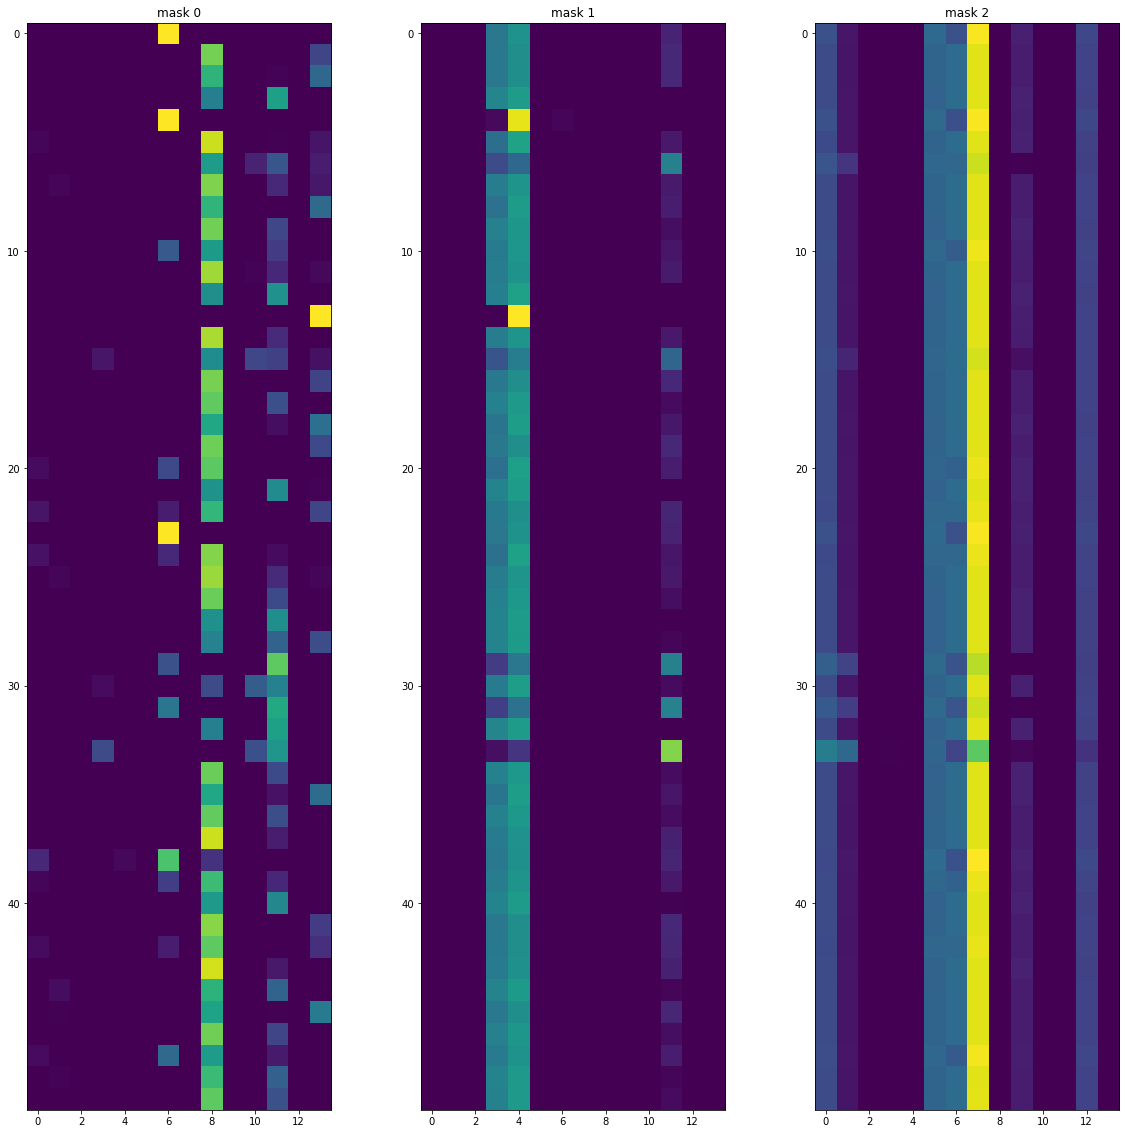

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(unsupervised_masks[i][:50])
    axs[i].set_title(f"mask {i}")

In [22]:
unsupervised_model.save_model('./test_pretrain')
loaded_pretrain = TabNetPretrainer()
loaded_pretrain.load_model('./test_pretrain.zip')


##%

clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, # how to use learning rate scheduler
                      "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax' # This will be overwritten if using pretrain model
)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    from_unsupervised=loaded_pretrain
)

Successfully saved model at ./test_pretrain.zip
Device used : cpu
Device used : cpu
Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.55172 | train_auc: 0.85401 | valid_auc: 0.86781 |  0:00:04s
epoch 1  | loss: 0.4249  | train_auc: 0.87945 | valid_auc: 0.88843 |  0:00:07s
epoch 2  | loss: 0.41561 | train_auc: 0.88863 | valid_auc: 0.89396 |  0:00:12s
epoch 3  | loss: 0.39339 | train_auc: 0.90286 | valid_auc: 0.90471 |  0:00:15s
epoch 4  | loss: 0.37293 | train_auc: 0.91302 | valid_auc: 0.91669 |  0:00:19s
epoch 5  | loss: 0.35984 | train_auc: 0.91855 | valid_auc: 0.91839 |  0:00:23s
epoch 6  | loss: 0.35374 | train_auc: 0.91954 | valid_auc: 0.92329 |  0:00:27s
epoch 7  | loss: 0.34787 | train_auc: 0.92426 | valid_auc: 0.92504 |  0:00:31s
epoch 8  | loss: 0.34969 | train_auc: 0.9228  | valid_auc: 0.9218  |  0:00:35s
epoch 9  | loss: 0.34444 | train_auc: 0.92694 | valid_auc: 0.92835 |  0:00:39s
epoch 10 | loss: 0.34347 | train_auc: 0.92636 | valid_auc: 0.9

/Users/ss/opt/anaconda3/envs/ncaa/lib/python3.7/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42]
  warnings.warn(wrn_msg)
/Users/ss/opt/anaconda3/envs/ncaa/lib/python3.7/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/ss/opt/anaconda3/envs/ncaa/lib/python3.7/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  warnings.warn(wrn_msg)
/Users/ss/opt/anaconda3/envs/ncaa/lib/python3.7/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)


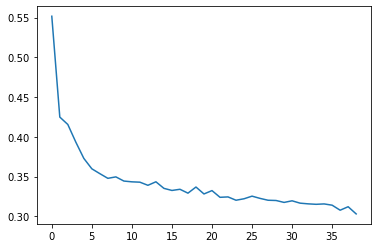

In [23]:
plt.plot(clf.history['loss'])

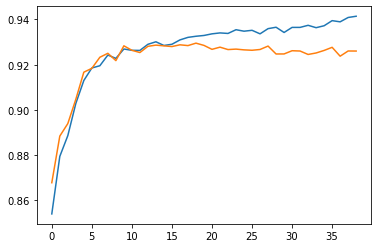

In [24]:
# plot auc
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

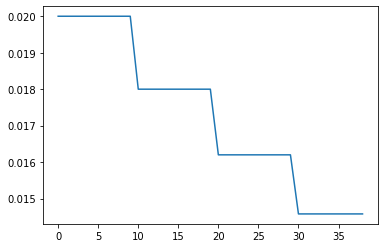

In [25]:
# plot learning rates
plt.plot(clf.history['lr'])

In [26]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)

preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

BEST VALID SCORE FOR census-income : 0.9295297973308444
FINAL TEST SCORE FOR census-income : 0.9257830266298044


In [27]:
# check that best weights are used
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)

In [28]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [29]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

Device used : cpu
Device used : cpu


In [30]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")

FINAL TEST SCORE FOR census-income : 0.9257830266298044


In [34]:
pd.DataFrame({"feature": features, "importance": clf.feature_importances_}).sort_values(by="importance", ascending=False)

,feature,importance
3,Bachelors,0.214705
8,White,0.160252
10,2174,0.117332
0,39,0.088918
6,Adm-clerical,0.085049
5,Never-married,0.078773
7,Not-in-family,0.067294
12,40,0.066029
11,0,0.063148
4,13,0.044157


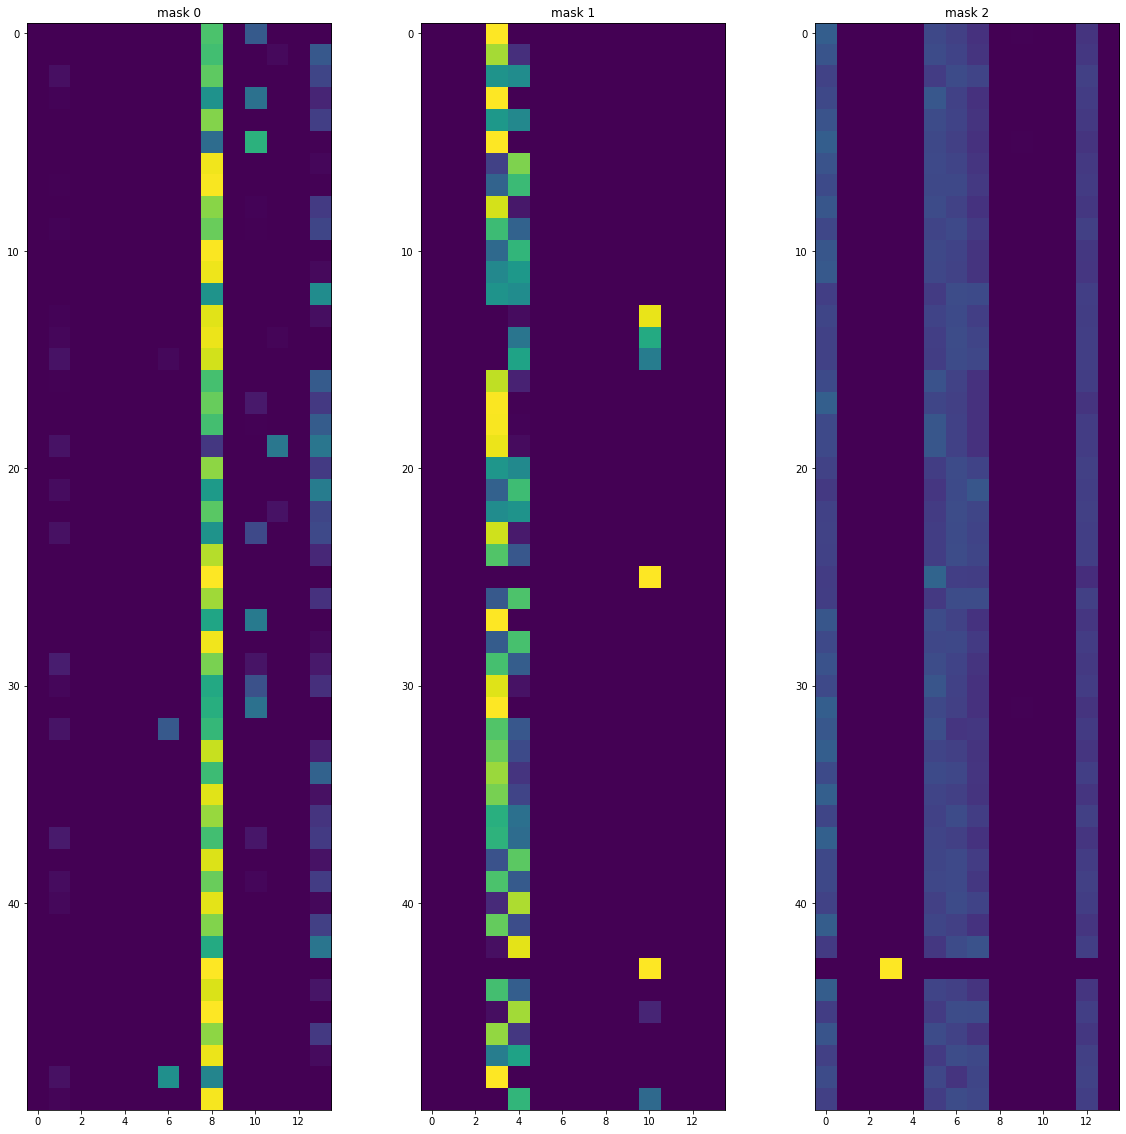

In [38]:
explain_matrix, masks = clf.explain(X_test)
fig, axs = plt.subplots(1, 3, figsize=(20,20))
for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")
plt.show()